In [1]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
zip_file_path = '/content/flower.zip'
extract_path = 'flowers'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
img_height, img_width = 150, 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  #20% data for validation
)

train_generator = train_datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  #'categorical' for multi-class
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 265 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


94765736/94765736 [==============================] - 0s 0us/step


In [6]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=15
)

Epoch 1/15
8/8 [==============================] - 35s 4s/step - loss: 2.5057 - accuracy: 0.6695 - val_loss: 0.6196 - val_accuracy: 0.8281
Epoch 2/15
8/8 [==============================] - 31s 4s/step - loss: 2.7214 - accuracy: 0.7897 - val_loss: 1.1389 - val_accuracy: 0.8438
Epoch 3/15
8/8 [==============================] - 30s 4s/step - loss: 1.3204 - accuracy: 0.6266 - val_loss: 0.9751 - val_accuracy: 0.8281
Epoch 4/15
8/8 [==============================] - 30s 4s/step - loss: 0.9714 - accuracy: 0.8155 - val_loss: 0.4901 - val_accuracy: 0.8281
Epoch 5/15
8/8 [==============================] - 30s 4s/step - loss: 0.5922 - accuracy: 0.7124 - val_loss: 0.5295 - val_accuracy: 0.8281
Epoch 6/15
8/8 [==============================] - 30s 4s/step - loss: 0.4915 - accuracy: 0.8197 - val_loss: 0.4683 - val_accuracy: 0.8281
Epoch 7/15
8/8 [==============================] - 30s 4s/step - loss: 0.5019 - accuracy: 0.8197 - val_loss: 0.4400 - val_accuracy: 0.8438
Epoch 8/15
8/8 [==================

In [8]:
#unfreeze base model layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
8/8 [==============================] - 108s 11s/step - loss: 0.8600 - accuracy: 0.7167 - val_loss: 0.4710 - val_accuracy: 0.8281
Epoch 2/10
8/8 [==============================] - 98s 12s/step - loss: 0.6433 - accuracy: 0.7773 - val_loss: 0.4442 - val_accuracy: 0.8438
Epoch 3/10
8/8 [==============================] - 89s 12s/step - loss: 0.4956 - accuracy: 0.8369 - val_loss: 0.4653 - val_accuracy: 0.8281
Epoch 4/10
8/8 [==============================] - 88s 11s/step - loss: 0.2906 - accuracy: 0.8798 - val_loss: 0.4698 - val_accuracy: 0.8281
Epoch 5/10
8/8 [==============================] - 89s 12s/step - loss: 0.2704 - accuracy: 0.8970 - val_loss: 0.4705 - val_accuracy: 0.8281
Epoch 6/10
8/8 [==============================] - 89s 11s/step - loss: 0.2134 - accuracy: 0.9185 - val_loss: 0.4689 - val_accuracy: 0.8281
Epoch 7/10
8/8 [==============================] - 89s 11s/step - loss: 0.1772 - accuracy: 0.9270 - val_loss: 0.4491 - val_accuracy: 0.8438
Epoch 8/10
8/8 [==========

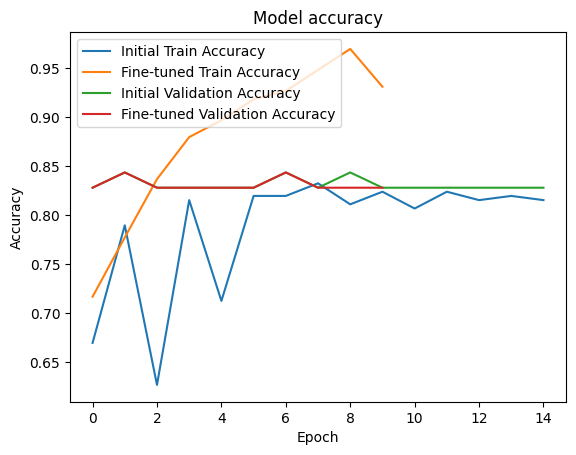

In [10]:
plt.plot(history.history['accuracy'], label='Initial Train Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Fine-tuned Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

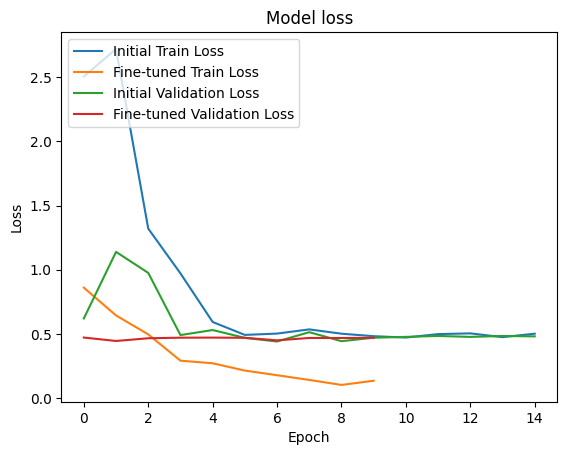

In [11]:
plt.plot(history.history['loss'], label='Initial Train Loss')
plt.plot(history_fine_tune.history['loss'], label='Fine-tuned Train Loss')
plt.plot(history.history['val_loss'], label='Initial Validation Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Fine-tuned Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [12]:
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

3/3 [==============================] - 8s 2s/step


In [13]:
# Get the true labels from the validation generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

In [14]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

    training       0.83      1.00      0.91        54
  validation       0.00      0.00      0.00        11

    accuracy                           0.83        65
   macro avg       0.42      0.50      0.45        65
weighted avg       0.69      0.83      0.75        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


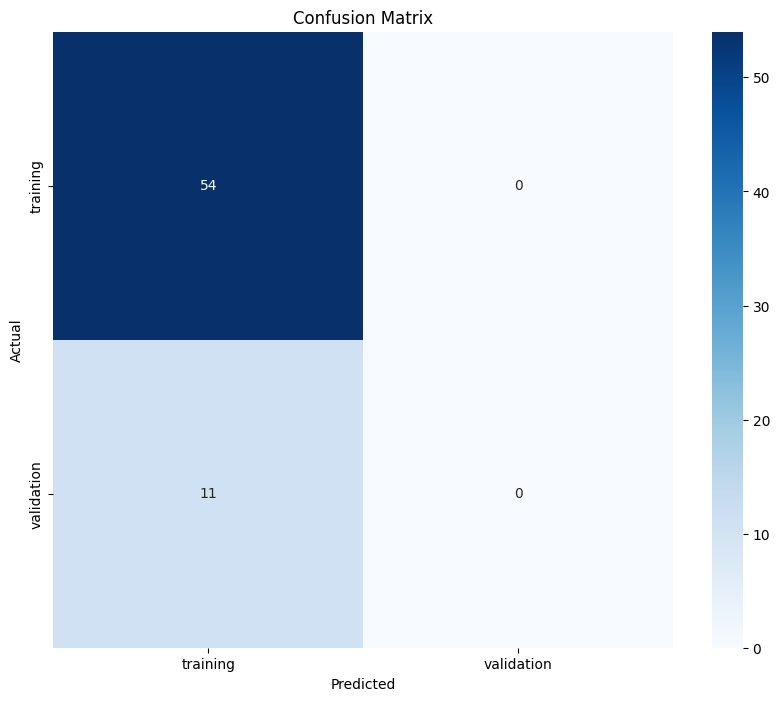

In [15]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()